In [1]:
import os
import numpy as np

from nibabel.testing import data_path
import nibabel as nib

In [2]:
# Global variables
ROOT_DIR = "/net/i/broseau/Travail/3A/FouilleExtrcVisu/2019_ENSEIRB_Skull/"
DATA_DIR = '/tmp/broseau_data/nifti/'
TRAIN_DATA_PROPORTION = 0.8 # Proportion of data used for training

## Initializing dataset

In [3]:
# Getting all the data files
dataset_data, dataset_labels = [], []
dataset_data_headers, dataset_labels_headers = [], []
i_data, i_label = 0, 0
for subdir, dirs, files in os.walk(DATA_DIR):
    for file in files:
        filename = os.path.join(subdir, file)
        if filename.endswith(".nii") and not "nifti_em" in filename:
            # Adding source data into dataset_data
            if not ("-labels" in filename):
                tmp = nib.load(filename)
                dataset_data.append(tmp.get_fdata())
                dataset_data_headers.append(tmp.header)
                print("Added to train data:", i_data,":\t", filename)
                i_data += 1
            # Adding label data into dataset_labels
            else:
                tmp = nib.load(filename)
                dataset_labels.append(tmp.get_fdata())
                dataset_labels_headers.append(tmp.header)
                print("Added to label data:", i_label, ":\t", filename)
                i_label += 1
            
dataset_data = np.array(dataset_data, dtype=np.float32) 
dataset_labels = np.array(dataset_labels, dtype=np.int8)

# Verifying training data is valid
assert(dataset_data.shape == dataset_labels.shape)
print("Dataset shape: ", dataset_data.shape)

Added to train data: 0 :	 /tmp/broseau_data/nifti/541/Shank_541.ibw.nii
Added to label data: 0 :	 /tmp/broseau_data/nifti/541/Shank_541-labels.nii
Added to label data: 1 :	 /tmp/broseau_data/nifti/499/Shank_499-labels.nii
Added to train data: 1 :	 /tmp/broseau_data/nifti/499/Shank_499.ibw.nii
Added to train data: 2 :	 /tmp/broseau_data/nifti/522/Shank_522.ibw.nii
Added to label data: 2 :	 /tmp/broseau_data/nifti/522/Shank_522-labels.nii
Added to train data: 3 :	 /tmp/broseau_data/nifti/527/Shank_527.ibw.nii
Added to label data: 3 :	 /tmp/broseau_data/nifti/527/Shank_527-labels.nii
Added to label data: 4 :	 /tmp/broseau_data/nifti/528/Shank_528-labels.nii
Added to train data: 4 :	 /tmp/broseau_data/nifti/528/Shank_528.ibw.nii
Added to label data: 5 :	 /tmp/broseau_data/nifti/536/Shank_536-labels.nii
Added to train data: 5 :	 /tmp/broseau_data/nifti/536/Shank_536.ibw.nii
Added to label data: 6 :	 /tmp/broseau_data/nifti/550/Shank_550c-labels.nii
Added to train data: 6 :	 /tmp/broseau_dat

In [4]:
def splitTrainingData(data, proportion):
    split_index = int(len(data)*proportion)
    tmp = np.split(data, [split_index, len(data)])
    return tmp[0], tmp[1]

In [5]:
# Splitting data into testing and training sets
X_train, X_test  = splitTrainingData(dataset_data, TRAIN_DATA_PROPORTION)
Y_train, Y_test  = splitTrainingData(dataset_labels, TRAIN_DATA_PROPORTION)

# Verifying training data is valid
assert(X_train.shape == Y_train.shape and X_test.shape == Y_test.shape)
print("Training data:", X_train.shape[0], "\nTesting data: ", X_test.shape[0])

Training data: 12 
Testing data:  4


In [6]:
# Printing maximum value for each dataset
shape = Y_train[0].shape
for data in Y_train:
    assert data.shape == shape
for data in Y_test:
    assert data.shape == shape
for data in X_train:
    assert data.shape == shape
for data in X_test:
    assert data.shape == shape
print("All the data ha the same shape.")

All the data ha the same shape.


In [7]:
print("Data shape:", Y_train[0].shape)
print("Data type of label:", Y_train[0].dtype)
print("Data type of data:", X_train[0].dtype)

Data shape: (128, 128, 128)
Data type of label: int8
Data type of data: float32


In [8]:
# Printing maximum value for each dataset
for data in Y_train:
    print("Max value a data from Y_train:",np.max(data))
for data in Y_test:
    print("Max value a data from Y_test:",np.max(data))

def removeUnusedLabels(dataset):
    f = np.vectorize(lambda x: 1 if x == 2. else 0, otypes=[np.int8])
    return f(dataset)

Y_train = removeUnusedLabels(Y_train)
Y_test  = removeUnusedLabels(Y_test)

# Verifying label data validity
assert np.max(Y_train) == 1., "Y_train has "+str(np.max(Y_train))+", expected 1."
assert np.max(Y_test) == 1., "Y_test has "+str(np.max(Y_test))+", expected 1."
assert(X_train.shape == Y_train.shape and X_test.shape == Y_test.shape)
print("Reformated labels")

Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 2
Max value a data from Y_train: 1
Max value a data from Y_test: 2
Max value a data from Y_test: 2
Max value a data from Y_test: 2
Max value a data from Y_test: 2
Reformated labels


# Augmenting dataset

In [9]:
#TODO
#from scipy.spatial.transform import Rotation as R

#r = R.from_matrix(np.random.random_sample((3, 3)))
#rotated = r.apply(X_test[0])
#print(rotated.shape, X_test[0].shape)

from numpy import sin, cos
theta = np.radians(30)
for s, e in combinations(np.array(list(product(d,d,d))), 2):
    if np.sum(np.abs(s-e)) == d[1]-d[0]:
        s_rotated = [s[0] * cos(theta) - s[1] * sin(theta), 
                     s[0] * sin(theta) + s[1] * cos(theta),
                     s[2]]
        e_rotated = [e[0] * cos(theta) - e[1] * sin(theta), 
                     e[0] * sin(theta) + e[1] * cos(theta),
                     e[2]]      
        ax.plot3D(*zip(s_rotated,e_rotated), color="g")

In [10]:
# plot3D: https://stackoverflow.com/questions/18789232/rotate-a-3d-object-in-python

# Creating model

In [11]:
# Reshaping data to fit in the model
X_test  = X_test.reshape((X_test.shape[0], 128,128,128,1))
X_train = X_train.reshape((X_train.shape[0], 128,128,128,1))
Y_test  = Y_test.reshape((Y_test.shape[0], 128,128,128,1))
Y_train = Y_train.reshape((Y_train.shape[0], 128,128,128,1))

In [12]:
#taken from https://github.com/zhixuhao/unet/blob/master/model.py
#TODO: verify shapes and network in itself

import skimage.io as io
import skimage.transform as trans
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras


def unet3D(pretrained_weights = None, input_size = (128,128,128,1)):
    inputs = Input(input_size)
    conv1 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv2 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    
    conv5 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv5 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up7 = Conv3D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 4)
    conv7 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv3D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv3D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 4)
    conv8 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv3D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv3D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 4)
    conv9 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv3D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    #TODO: custom accuracy ou une accuracy plus adaptée
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [13]:
model = unet3D()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 224         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 1736        conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 64, 64, 64, 8 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
NB_EPOCHS = 1
BATCH_SIZE = 1

In [15]:
# Training Model on GPU if available\n",
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device = tf.device('/GPU:0') if tf.test.is_gpu_available() else tf.device('/CPU:0')
print("Using GPU: ", tf.test.is_gpu_available())

Num GPUs Available:  0
Using GPU:  False


In [16]:
with device:
    model.fit(X_train, Y_train,
        epochs=NB_EPOCHS, batch_size=BATCH_SIZE,
        validation_data=(X_test, Y_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss')])

Train on 12 samples, validate on 4 samples
12/12 [==============================] - 139s 12s/sample - loss: 3719.0550 - binary_accuracy: 0.3380 - val_loss: 715.2851 - val_binary_accuracy: 0.6484


In [17]:
model.save_weights("model.h5")

In [30]:
import nilearn.plotting as nplt 

def generateMask(prediction, threshold=0.5):
    """ Returns prediction as an array containing 0 and 1.
        threshold is applied on each values """
    f = lambda a: 1 if a >= threshold else 0
    return np.where(prediction >= threshold, 1, 0).astype(np.int8)

def saveMask(data, path, header=None):
    img = nib.Nifti1Image(data, np.eye(4))
    if header is not None:
        img.header = header
    nib.save(img, path)

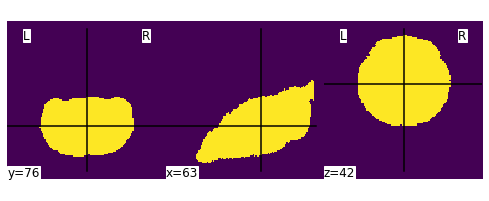

In [31]:
saveMask(dataset_labels[-1], "ground_truth.nii")
nplt.plot_img("ground_truth.nii")


In [27]:
predictions = generateMask(model.predict(X_test))
predictions = predictions.reshape((predictions.shape[0], 128,128,128))

int8


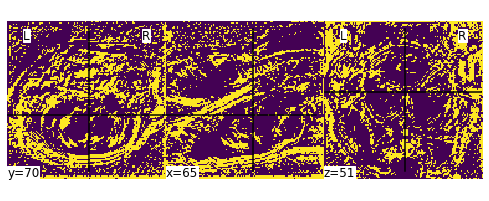

In [34]:
saveMask(predictions[0], "prediction.nii")

import nilearn.plotting as nplt 
nplt.plot_img("prediction.nii")

# Soutenance: 

## Statistiques (beaucoup)
## Explication des résultats
## Explication du pourquoi du comment
## Faire un ou plusieurs DICE, Intersection/Union, Jackard
## Matrice de confusion
## Couches intermédiaires du réseau
## Métriques slices par slices
## (voir diapo)
https://www.rmsb.u-bordeaux.fr/nextcloud/index.php/s/6oMjTeDtmREpMgC

https://playground.tensorflow.org

Outil pour visualiser des .nii : itksnap